### Cab-Driver Agent

In [1]:
# Importing libraries
import numpy as np
import random
import math
from collections import deque
import collections
import pickle
import math
# for building DQN model
from keras import layers
from keras import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.layers.convolutional import Conv2D
from keras.optimizers import Adam
from keras.layers import LeakyReLU

# for plotting graphs
import matplotlib.pyplot as plt
import tqdm
import time

import warnings
warnings.filterwarnings("ignore")


In [2]:
#from google.colab import drive
#drive.mount('/gdrive',force_remount=True)

In [3]:
#Import the environment
import os
#path="/gdrive/MyDrive/RL/RL Project(Cab-Driver)-Code Structure"
path=os.getcwd()

In [4]:
os.cpu_count()

4

In [4]:
path

'/mnt/disks/user/project'

In [5]:
#MODULE_PATH = "/gdrive/MyDrive/RL/RL Project(Cab-Driver)-Code Structure/Env.py"
MODULE_PATH =path+"//Env.py"
MODULE_NAME = "Env"
import importlib
import sys
spec = importlib.util.spec_from_file_location(MODULE_NAME, MODULE_PATH)
Env = importlib.util.module_from_spec(spec)
sys.modules[spec.name] = Env
spec.loader.exec_module(Env)
from Env import CabDriver

In [6]:
env=CabDriver()

In [7]:
# Loading the time matrix provided
Time_matrix = np.load(path+"/TM.npy")

In [8]:
Time_matrix.shape

(5, 5, 24, 7)

In [9]:
Time_matrix[0][1][2][1]

3.0

In [10]:
env.action_space

[(0, 0),
 (0, 1),
 (0, 2),
 (0, 3),
 (0, 4),
 (1, 0),
 (1, 2),
 (1, 3),
 (1, 4),
 (2, 0),
 (2, 1),
 (2, 3),
 (2, 4),
 (3, 0),
 (3, 1),
 (3, 2),
 (3, 4),
 (4, 0),
 (4, 1),
 (4, 2),
 (4, 3)]

In [11]:
env.reward_func([0,1,2],20, Time_matrix)

-1

#### Tracking the state-action pairs for checking convergence


In [12]:
track_states = {'0-0-0':{}}

In [13]:
def str_key(action):
    k=''
    for i in list(action):
        k=k+'-'+str(i)
    return k[1:]

In [14]:
for i in env.action_space[1:4]:
    track_states['0-0-0'][str_key(i)]=[]

In [15]:
track_states

{'0-0-0': {'0-1': [], '0-2': [], '0-3': []}}

In [16]:
#Defining a function to save the Q-dictionary as a pickle file
def save_obj(obj, name ):
    with open(path+'//'+name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

### Agent Class

If you are using this framework, you need to fill the following to complete the following code block:
1. State and Action Size
2. Hyperparameters
3. Create a neural-network model in function 'build_model()'
4. Define epsilon-greedy strategy in function 'get_action()'
5. Complete the function 'append_sample()'. This function appends the recent experience tuple <state, action, reward, new-state> to the memory
6. Complete the 'train_model()' function with following logic:
   - If the memory size is greater than mini-batch size, you randomly sample experiences from memory as per the mini-batch size and do the following:
      - Initialise your input and output batch for training the model
      - Calculate the target Q value for each sample: reward + gamma*max(Q(s'a,))
      - Get Q(s', a) values from the last trained model
      - Update the input batch as your encoded state-action and output batch as your Q-values
      - Then fit your DQN model using the updated input and output batch.

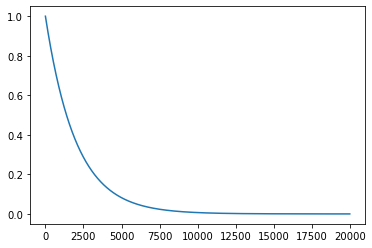

In [28]:
x=[i for i in range(20000)]
y=[0 for i in range(20000)]
y[0]=1
for i in range(1,20000):
    if y[i-1]>0.0001:
        y[i]=y[i-1]*0.9995
plt.plot(y)

In [18]:
y[-1]

0

In [34]:
# Defining hyperparameters
m = 5 # number of cities, ranges from 1 ..... m
t = 24 # number of hours, ranges from 0 .... t-1
d = 7  # number of days, ranges from 0 ... d-1
C = 5 # Per hour fuel and other costs
R = 9 # per hour revenue from a passenger
env=CabDriver()
class DQNAgent:
    def __init__(self):
        # Define size of state and action
        
        self.state_size = m+t+d
        self.action_size = len(env.action_space)

        # Write here: Specify you hyper parameters for the DQN
        self.discount_factor = 0.95
        self.learning_rate = 0.01      
        self.epsilon = 1
        self.epsilon_decay = 0.9995
        self.epsilon_min = 0.0001
        self.batch_size = 32        
        # create replay memory using deque
        self.memory = deque(maxlen=2000)

        # create main model and target model
        self.model = self.build_model()
        

    # approximate Q function using Neural Network
    def build_model(self):
        model = Sequential()
        self.dim=int(math.sqrt(self.state_size))
        model.add(Conv2D(filters=16, kernel_size=4, activation='relu', input_shape=(self.dim,self.dim,1),data_format="channels_last"))
        model.add(Flatten())

        #model.add(Dense(self.batch_size, input_dim=self.state_size, activation='relu',kernel_initializer='he_uniform'))
        model.add(Dense(self.batch_size, activation='relu',kernel_initializer='he_uniform'))
        #model.add(Dense(self.batch_size, input_dim=self.state_size))
        #model.add(LeakyReLU(alpha=0.1))
        #model.add(Dense(self.batch_size*2))
        #model.add(LeakyReLU(alpha=0.1))
        model.add(Dense(self.action_size, activation='relu',kernel_initializer='he_uniform'))
        # Write your code here: Add layers to your neural nets       
        model.compile(loss='mse',optimizer=Adam(lr=self.learning_rate))
        
        return model



    def get_action(self, state):
        #se=env.state_encod_arch2(state)
        #se=np.array(se).reshape(1,self.state_size)
        se=env.state_encod_arch2(state)
        se=np.array(se).reshape(1,self.dim,self.dim,1)
        possible_actions_index,actions=env.requests(state)
        # Write your code here:
        # get action from model using epsilon-greedy policy
        # Decay in ε after we generate each sample from the environment       
        if np.random.rand() <= self.epsilon:
            return random.choice(possible_actions_index)
        # if generated random number is greater than ε, choose the action which has max Q-value
        else:
            q_value = self.model.predict(se)
            q_vals_possible = [q_value[0][i] for i in possible_actions_index]
            return possible_actions_index[np.argmax(q_vals_possible)]
    

    def append_sample(self, state, action, reward, next_state,done):
        # Write your code here:
        # save sample <s,a,r,s'> to the replay memory
        self.memory.append((state, action, reward, next_state, done))
        # Decay in ε after we generate each sample from the environment
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    # pick samples randomly from replay memory (with batch_size) and train the network
    def train_model(self):
        if len(self.memory) > self.batch_size:
            # Sample batch from the memory
            mini_batch = random.sample(self.memory, self.batch_size)
            
            #update_output = np.zeros((self.batch_size, self.state_size)) # write here
            #update_input = np.zeros((self.batch_size, self.state_size)) # write here
            update_output = np.zeros((self.batch_size, self.dim,self.dim,1)) # write here
            update_input = np.zeros((self.batch_size, self.dim,self.dim,1))
            actions, rewards,dones = [], [],[]
            
            for i in range(self.batch_size):
                state, action, reward, next_state,done = mini_batch[i]
                
                #update_output[i] = env.state_encod_arch2(state)
                
                update_output[i]=np.array(env.state_encod_arch2(state)).reshape(self.dim,self.dim,1)
                
                actions.append(action)
                rewards.append(reward)
                dones.append(done)
                
                #update_output[i] = env.state_encod_arch2(next_state)
                
                update_output[i]=np.array(env.state_encod_arch2(next_state)).reshape(self.dim,self.dim,1)
            
            # 1. Predict the target from earlier model
            target = self.model.predict(update_input)
               
            # 2. Get the target for the Q-network
            target_qval = self.model.predict(update_output)

            #3. Update your 'update_output' and 'update_input' batch. Be careful to use the encoded state-action pair
            for i in range(self.batch_size):
                if dones[i]:
                    target[i][actions[i]] = rewards[i]
                else:# non-terminal state
                    target[i][actions[i]] = rewards[i] + self.discount_factor * np.max(target_qval[i])
            # 4. Fit your model and track the loss values
            self.model.fit(update_input, target, batch_size=self.batch_size, epochs=1, verbose=0)



    def save(self, name):
        self.model.save_weights(name)

In [35]:
total_rewards=[]
dqn=DQNAgent()

In [ ]:
with open(path+'//'+'States.pkl', 'rb') as f:
        track_states=pickle.load(f)
with open(path+'//'+'total_rewards.pkl', 'rb') as f:
        total_rewards=pickle.load(f)

In [36]:
Episodes = 20000
ran_int=2000
from_ep=list(range(1,Episodes,ran_int))
to_ep=list(range(ran_int,Episodes+ran_int,ran_int))

In [37]:
from_ep,to_ep

([1, 2001, 4001, 6001, 8001, 10001, 12001, 14001, 16001, 18001],
 [2000, 4000, 6000, 8000, 10000, 12000, 14000, 16000, 18000, 20000])

In [ ]:
for episode in tqdm.tqdm(range(from_ep[0],to_ep[0]+1)):

    # Write code here
    # Call the environment
    # Call all the initialised variables of the environment
    env.reset()
    action_space = env.action_space
    state_space = env.state_space
    state_init = env.state_init
    #print(dqn.epsilon)
    state = state_init
    #print(state)
    acc_reward=0
    done=False
    action = dqn.get_action(state)
    reward = env.reward_func(state, action, Time_matrix)
    next_state,t1,t2 = env.next_state_func(state, action, Time_matrix)
    tot_time=t1+t2
    #while tot_time<720:
    t_ct=0
    while not done:
        #ch_reward = env.reward_func(state, action, Time_matrix)
        next_ch_state,t12,t22 = env.next_state_func(next_state, dqn.get_action(next_state), Time_matrix)
        ch_time_trip=t12+t22
        if tot_time+ch_time_trip>=720:
            done=True
        #print(done)
        
        dqn.append_sample(state, action, reward, next_state, done)
        state=next_state
       
        action = dqn.get_action(state)
        reward = env.reward_func(state, action, Time_matrix)
        next_state,t1,t2 = env.next_state_func(state, action, Time_matrix)
        time_trip=t1+t2
        tot_time=tot_time+time_trip
        acc_reward=acc_reward+reward
        t_ct=t_ct+1
        if t_ct==30:
            dqn.train_model()


#    str_state=str_key(state_init)
#    if str_state in track_states.keys():
#        track_states[str_state].append(acc_reward)
        
    #total_rewards.append(acc_reward)
    
        # Write your code here
        # 1. Pick epsilon-greedy action from possible actions for the current state
        # 2. Evaluate your reward and next state
        # 3. Append the experience to the memory
        # 4. Train the model by calling function agent.train_model
        # 5. Keep a track of rewards, Q-values, loss
        
    if episode%100==0:
        se=np.zeros((1,dqn.dim,dqn.dim,1))
                        
        #qvals_track=dqn.model.predict(np.array(se).reshape(1,dqn.state_size))
        qvals_track=dqn.model.predict(se)
        track_states['0-0-0']['0-1'].append(qvals_track[0][1])
        track_states['0-0-0']['0-2'].append(qvals_track[0][2])
        track_states['0-0-0']['0-3'].append(qvals_track[0][3])
        total_rewards.append(acc_reward)
        save_obj(track_states,'States')
        save_obj(total_rewards,'total_rewards')
        dqn.save(path+"/Final_model.h5")


 26%|██▋       | 525/2000 [1:10:05<3:08:49,  7.68s/it]

In [ ]:
dqn.model.load_weights(path+"/Final_model.h5")

In [26]:
for episode in tqdm.tqdm(range(2214,to_ep[0]+1)):

    # Write code here
    # Call the environment
    # Call all the initialised variables of the environment
    env.reset()
    action_space = env.action_space
    state_space = env.state_space
    state_init = env.state_init
    #print(dqn.epsilon)
    state = state_init
    #print(state)
    acc_reward=0
    done=False
    action = dqn.get_action(state)
    reward = env.reward_func(state, action, Time_matrix)
    next_state,t1,t2 = env.next_state_func(state, action, Time_matrix)
    tot_time=t1+t2
    #while tot_time<720:
    t_ct=0
    while not done:
        #ch_reward = env.reward_func(state, action, Time_matrix)
        next_ch_state,t12,t22 = env.next_state_func(next_state, dqn.get_action(next_state), Time_matrix)
        ch_time_trip=t12+t22
        if tot_time+ch_time_trip>=720:
            done=True
        #print(done)
        
        dqn.append_sample(state, action, reward, next_state, done)
        state=next_state
       
        action = dqn.get_action(state)
        reward = env.reward_func(state, action, Time_matrix)
        next_state,t1,t2 = env.next_state_func(state, action, Time_matrix)
        time_trip=t1+t2
        tot_time=tot_time+time_trip
        acc_reward=acc_reward+reward
        t_ct=t_ct+1
        if t_ct==25:
            dqn.train_model()
            se=np.zeros((1,dqn.dim,dqn.dim,1))
                        
            #qvals_track=dqn.model.predict(np.array(se).reshape(1,dqn.state_size))
            qvals_track=dqn.model.predict(se)
            track_states['0-0-0']['0-1'].append(qvals_track[0][1])
            track_states['0-0-0']['0-2'].append(qvals_track[0][2])
            track_states['0-0-0']['0-3'].append(qvals_track[0][3])

#    str_state=str_key(state_init)
#    if str_state in track_states.keys():
#        track_states[str_state].append(acc_reward)
        
    total_rewards.append(acc_reward)
    
        # Write your code here
        # 1. Pick epsilon-greedy action from possible actions for the current state
        # 2. Evaluate your reward and next state
        # 3. Append the experience to the memory
        # 4. Train the model by calling function agent.train_model
        # 5. Keep a track of rewards, Q-values, loss
        
    if episode%100==0:
        save_obj(track_states,'States')
        save_obj(total_rewards,'total_rewards')
        dqn.save(path+"/Final_model.h5")


100%|██████████| 787/787 [1:37:36<00:00,  7.44s/it]


In [ ]:
for episode in tqdm.tqdm(range(from_ep[1],to_ep[1]+1)):

    # Write code here
    # Call the environment
    # Call all the initialised variables of the environment
    env.reset()
    action_space = env.action_space
    state_space = env.state_space
    state_init = env.state_init
    #print(dqn.epsilon)
    state = state_init
    #print(state)
    acc_reward=0
    done=False
    action = dqn.get_action(state)
    reward = env.reward_func(state, action, Time_matrix)
    next_state,t1,t2 = env.next_state_func(state, action, Time_matrix)
    tot_time=t1+t2
    #while tot_time<720:
    t_ct=0
    while not done:
        #ch_reward = env.reward_func(state, action, Time_matrix)
        next_ch_state,t12,t22 = env.next_state_func(next_state, dqn.get_action(next_state), Time_matrix)
        ch_time_trip=t12+t22
        if tot_time+ch_time_trip>=720:
            done=True
        #print(done)
        
        dqn.append_sample(state, action, reward, next_state, done)
        state=next_state
       
        action = dqn.get_action(state)
        reward = env.reward_func(state, action, Time_matrix)
        next_state,t1,t2 = env.next_state_func(state, action, Time_matrix)
        time_trip=t1+t2
        tot_time=tot_time+time_trip
        acc_reward=acc_reward+reward
        t_ct=t_ct+1
        if t_ct==25:
            dqn.train_model()
            se=np.zeros((1,dqn.dim,dqn.dim,1))
                        
            #qvals_track=dqn.model.predict(np.array(se).reshape(1,dqn.state_size))
            qvals_track=dqn.model.predict(se)
            track_states['0-0-0']['0-1'].append(qvals_track[0][1])
            track_states['0-0-0']['0-2'].append(qvals_track[0][2])
            track_states['0-0-0']['0-3'].append(qvals_track[0][3])

#    str_state=str_key(state_init)
#    if str_state in track_states.keys():
#        track_states[str_state].append(acc_reward)
        
    total_rewards.append(acc_reward)
    
        # Write your code here
        # 1. Pick epsilon-greedy action from possible actions for the current state
        # 2. Evaluate your reward and next state
        # 3. Append the experience to the memory
        # 4. Train the model by calling function agent.train_model
        # 5. Keep a track of rewards, Q-values, loss
        
    if episode%100==0:
        save_obj(track_states,'States')
        save_obj(total_rewards,'total_rewards')
        dqn.save(path+"/Final_model.h5")


  6%|▌         | 172/3000 [21:34<5:47:57,  7.38s/it]

In [184]:
tot_time

718

In [185]:
next_state,action

([0, 10, 0], 17)

### Tracking Convergence

In [22]:
with open(path+'//'+'States.pkl', 'rb') as f:
        track_states=pickle.load(f)
with open(path+'//'+'total_rewards.pkl', 'rb') as f:
        total_rewards=pickle.load(f)

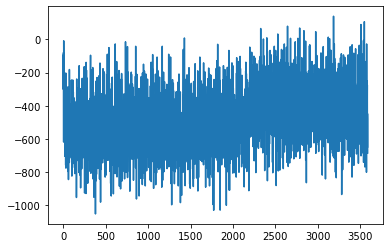

In [23]:
plt.plot(total_rewards)

TypeError: float() argument must be a string or a number, not 'dict'

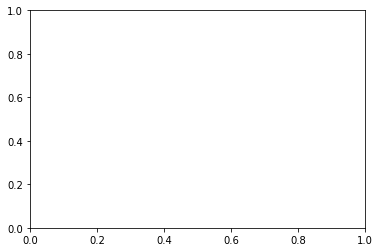

In [263]:
for i in track_states.keys():
    plt.plot(track_states[i])

#### Epsilon-decay sample function

<div class="alert alert-block alert-info">
Try building a similar epsilon-decay function for your model.
</div>

In [ ]:
time = np.arange(0,10000)
epsilon = []
for i in range(0,10000):
    epsilon.append(0 + (1 - 0) * np.exp(-0.0009*i))

In [ ]:
plt.plot(time, epsilon)
plt.show()